# Pytorch: RESNET-34

## 97.3% accuracy

In [4]:
# standard modules
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# pytorch modules
import torch as torch
from torch import nn
from torch import conv2d, convolution
import torchvision.models as models
from torchvision.models import * 
# fast.ai modules
from fastai import *
from fastai.basics import *
from fastai.script import *
from fastai.vision import *
from fastai.vision.models.wrn import wrn_22
from fastai.distributed import *
# GPU config
torch.backends.cudnn.benchmark = True

In [6]:
path = Path('data/')
torch.device('cuda', 0)

device(type='cuda', index=0)

In [7]:
for folder in ('NORMAL', 'CNV', 'DME', 'DRUSEN'):
    print(folder)
  #  verify_images(path/folder, delete=True, max_size=500)

NORMAL
CNV
DME
DRUSEN


In [8]:
sz=299 # image size
bs=32 # batch size
data = ImageDataBunch.from_folder(path, train='.', 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=sz,
                                  bs=bs,
                                  no_check=True,
                                  num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['CNV', 'DME', 'DRUSEN', 'NORMAL', 'test']

In [8]:
# build and train model 
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4) # run model with 4 cycles

C:\Users\Blair\Anaconda3\envs\oct\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Blair/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:04<00:00, 21.5MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.365213,0.256159,0.086884,13:46
1,0.250549,0.156462,0.050367,12:29
2,0.189409,0.138529,0.046342,12:35
3,0.194631,0.132410,0.044567,12:38


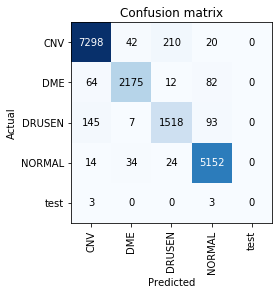

In [9]:
# save/load model
learn.save('stage-1-128')
learn.load('stage-1-128')

# classification model results
interpretation = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix evaluate errors
interpretation.plot_confusion_matrix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


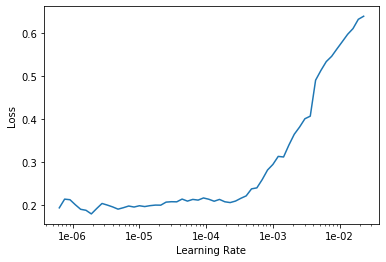

In [11]:
# find the best learning rate
learn.unfreeze()
learn.lr_find()

# plot the learning rate
learn.recorder.plot()

In [12]:
# train the model using new learning rate 2 cycles
lr = 1e-04 # learning rate
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.165647,0.118013,0.039595,15:07
1,0.154490,0.106807,0.034742,15:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


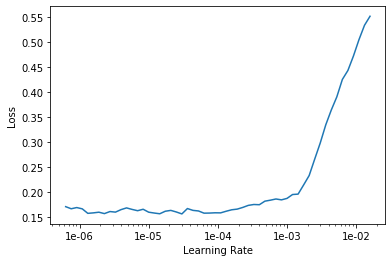

In [13]:
# create new ImageDataBunch with size 256
data_bigger = ImageDataBunch.from_folder(path,
                                        train=".",
                                        valid_pct=.2,
                                        ds_tfms=get_transforms(),
                                        size=256,
                                        num_workers=4).normalize(imagenet_stats)
# update the learn data for image size
learn.data = data_bigger
# unfreeze the model for learning rates
learn.unfreeze()
# plot the learning rate graph
lr_find(learn)
learn.recorder.plot()

In [14]:
# update learning rate, train
previous_lr = 1e-05
learn.fit_one_cycle(3, slice(1e-04, previous_lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.148190,0.117405,0.037583,09:47
1,0.130675,0.094433,0.029830,09:32
2,0.107663,0.085955,0.027876,09:41


In [15]:
learn.save('stage-2-transfer')

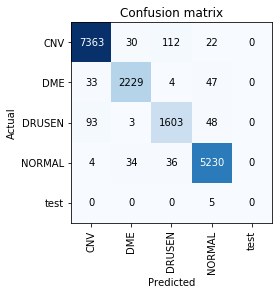

In [16]:
learn.load('stage-2-transfer')
# plot confusion matrix
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

In [9]:
# load stage 2 transfer
learn = create_cnn(data, models.resnet34, metrics=accuracy)

C:\Users\Blair\Anaconda3\envs\oct\lib\site-packages\fastai\vision\learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [73]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.130911,0.079459,0.973603,11:21
0,0.130911,0.079459,0.973603,11:21


In [ ]:
learn.load('stage-2-transfer')

# create new learner with the single data 
learn1 = create_cnn(d, models.resnet34, metrics=accuracy)

# load the previous model
learn1.load('stage-2-transfer')

classes = data.classes

# single data ImageDataBunch
d = ImageDataBunch.single_from_classes(path, 
                                       classes,
                                       ds_tfms=get_transforms(), 
                                       size=256).normalize(imagenet_stats)

Class:  CNV


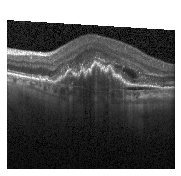

In [41]:
# load resize display test images
img_path='data/test/test/CNV-6294785-1.jpeg'
img_path2='data/test/test/DME-9721607-2.jpeg'
img_path3='data/test/test/DRUSEN-9928043-1.jpeg'
img_path4='data/test/test/NORMAL-9053621-1.jpeg'

# predictions, feed image
img = open_image(img_path)
img.show()

# return the predicted class, the index and the outputs
predicted_class, predicted_index, outputs = learn1.predict(img)
print('Class: ', predicted_class)

Class:  DME


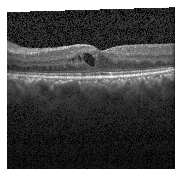

In [42]:
# predictions, feed image
img2 = open_image(img_path2)
img2.show()

# Get the predicted class, the index and the outputs
predicted_class, predicted_index, outputs = learn1.predict(img2)
print('Class: ', predicted_class)

Class:  DRUSEN


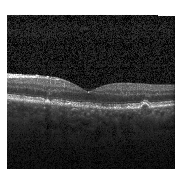

In [43]:
# predictions, feed image
img3 = open_image(img_path3)
img3.show()

# Get the predicted class, the index and the outputs
predicted_class, predicted_index, outputs = learn1.predict(img3)
print('Class: ', predicted_class)

Class:  NORMAL


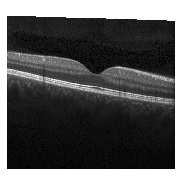

In [45]:
# predictions, feed image
img4 = open_image(img_path4)
img4.show()

# Get the predicted class, the index and the outputs
predicted_class, predicted_index, outputs = learn1.predict(img4)
print('Class: ', predicted_class)

In [ ]:
preds,y = learn.get_preds()
interp = ClassificationInterpretation(data, preds, y, loss_class=nn.CrossEntropyLoss)